## Optimization homework 1

done by: <i>Dei Rossi Alvise (#2004250), Corrado Lorenzo (#2020623), Vinco Riccardo (#2005800)</i>

## Section 1: Functions Definition

In [1]:
from sklearn import datasets
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import scipy
%matplotlib inline

In [2]:
def check_symmetric(a, rtol=1e-05, atol=1e-08):
    return np.allclose(a, a.T, rtol=rtol, atol=atol)    

In [3]:
def build_similarity_matrices(similarity_type="inverse_euclidean",sigma=0.5,epsilon=1):
    
    if similarity_type not in ["inverse_euclidean","gaussian"]:
        print("similarity type not available")
        return
    
    l = X_labeled.copy()
    l = l.reshape(num_labeled,1,num_features)
    u1 = X_unlabeled.copy()
    u2 = X_unlabeled.copy()
    u1 = u1.reshape(1,num_unlabeled,num_features)
    u2 = u2.reshape(num_unlabeled,1,num_features)
        
    if similarity_type == "inverse_euclidean":
        
        W_lu = 1/(epsilon+np.sum(((u1-l)**2),axis=2)**0.5)
        W_uu = 1/(epsilon+np.sum(((u1-u2)**2),axis=2)**0.5)
        assert(check_symmetric(W_uu))
        
        
    if similarity_type == "gaussian":

        W_lu = np.exp((-np.sum(((u1-l)**2),axis=2)/(2*sigma**2)))
        W_uu = np.exp((-np.sum(((u1-u2)**2),axis=2)/(2*sigma**2)))
        assert(check_symmetric(W_uu))
        
        
    return W_lu,W_uu

In [4]:
def standard_gd(x,Q,c,k,method,L=None,alpha0=1,delta=0.1,gamma=0.0001,verbose=False,max_iter=1000,epsilon=1e-4,stop_loss=0):
    losses = []
    grad_norms = []
    times = []
    flag = True
    n_iter = 0
    t0 = time.time()
    
    ## values to calculate gradient and loss: gradient = Qx-c, loss = 0.5*xQx-cx(+k) <--- k can be ignored 
    Qx = np.dot(Q,x)
    xQx = np.dot(x.T,Qx)
    cx = np.dot(c.T,x)
    loss = 0.5*xQx-cx+k
    
    while(flag):
        times.append(time.time()-t0)
        
        gradient = Qx-c
        d = -gradient
        grad_norm = np.dot(gradient.T,d)
        grad_norms.append(-grad_norm)
        
        losses.append(float(loss))
        
        if n_iter >= max_iter:
            break
        if loss <= stop_loss:
            break
        if np.abs(grad_norm) <= epsilon:
            break
        
        #stepsize selection
        if method == "armijo":
            ref = gamma*grad_norm
            alpha = alpha0
            
            while True:
                z = x+alpha*d
                Qz = np.dot(Q,z)
                zQz = np.dot(z.T,Qz)
                cz = np.dot(c.T,z)
                loss_z = 0.5*zQz-cz+k
                if loss_z <= loss + alpha*ref:
                    break
                else:
                    alpha = alpha*delta
                if alpha <= 1e-15:
                    z = x
                    loss_z = loss
                    flag = False
                    n_iter -= 1
                    break
                
        elif method == "exact":
            alpha = -grad_norm/(np.dot(np.dot(d.T,Q),d))
            z = x+alpha*d
            Qz = np.dot(Q,z)
            zQz = np.dot(z.T,Qz)
            cz = np.dot(c.T,z)
            loss_z = 0.5*zQz-cz+k
                
        elif method == "fixed":
            alpha = 1/L
            z = x+alpha*d
            Qz = np.dot(Q,z)
            zQz = np.dot(z.T,Qz)
            cz = np.dot(c.T,z)
            loss_z = 0.5*zQz-cz+k
                
        else:
            print("invalid step size selection method selected")
            break
            
        
        x=z
        Qx = Qz
        loss = loss_z
        
        if verbose:
            print(f"Iteration {n_iter+1}: loss {loss}\tselected step size {alpha}\tgradient norm {np.abs(grad_norm)}")
            print("\n")
        
        n_iter += 1
        
    return x,n_iter,losses,times,grad_norms

In [5]:
def randomized_BCGD(x,Q,c,k,method,L=None,alpha0=1,delta=0.1,gamma=0.0001,verbose=False,max_iter=5e5,epsilon=1e-12,stop_loss=0):
    losses = []
    grad_norms = []
    times = []
    flag = True
    n_iter = 0
    t0 = time.time()
    blocks = len(x)
    
    ## values to calculate gradient and loss: gradient = Qx-c, loss = 0.5*xQx-cx(+k) <--- k can be ignored 
    Qx = np.dot(Q,x)
    xQx = np.dot(x.T,Qx)
    cx = np.dot(c.T,x)
    loss = 0.5*xQx-cx+k
    
    while(flag):
        times.append(time.time()-t0)
        losses.append(float(loss))

        
        while True:
            idx = np.random.randint(0,blocks)
            Qix = np.dot(Q[idx,:],x)
            ci = c[idx]
            grad_i = Qix -ci
            Qii = Q[idx,idx]
            di = -grad_i
            if (di != 0):
                break
        
        grad_norm = np.dot(grad_i,di)
        grad_norms.append(grad_norm)
        
        if n_iter >= max_iter:
            break
        if loss <= stop_loss:
            break
        
        '''
        if np.abs(blocks*grad_norm) <= epsilon:
            print("uscito per norma del gradiente")
            break
        '''
        
        z = x
          
        if method == "exact":
            alpha = 1/Qii
            z[idx] = x[idx]+alpha*di
            loss_z = loss + alpha*di*grad_i + 0.5*((alpha*di)**2)*Qii
                
        elif method == "fixed":
            alpha = 1/L
            z[idx] = x[idx]+alpha*di
            loss_z = loss + alpha*di*grad_i + 0.5*((alpha*di)**2)*Qii
                
        else:
            print("invalid step size selection method selected")
            break
        
        x=z
        loss = loss_z
        
        if verbose and (n_iter+1)%10000==0:
            print(f"Iteration {n_iter+1}: loss {loss}\tselected step size {alpha}\tgradient norm {np.abs(grad_norm)}")
            print("\n")
        
        n_iter += 1
    
    return x,n_iter,losses,times,grad_norms
        

In [6]:
def cyclic_BCGD(x,Q,c,k,method,L=None,alpha0=1,delta=0.1,gamma=0.0001,verbose=False,max_iter=1000,epsilon=1e-8,stop_loss=0):
    losses = []
    grad_norms = []
    times = []
    flag = True
    n_iter = 0
    t0 = time.time()
    blocks = len(x)
    
    ## values to calculate gradient and loss: gradient = Qx-c, loss = 0.5*xQx-cx(+k) <--- k can be ignored 
    Qx = np.dot(Q,x)
    xQx = np.dot(x.T,Qx)
    cx = np.dot(c.T,x)
    loss = 0.5*xQx-cx+k
    
    while(flag):
        times.append(time.time()-t0)
        losses.append(float(loss))
        
        if n_iter >= max_iter:
            break
        if loss <= stop_loss:
            break
        
        z = x
        
        for idx in range(blocks):
            Qix = np.dot(Q[idx,:],x)
            ci = c[idx]
            grad_i = Qix -ci
            Qii = Q[idx,idx]
            di = -grad_i
            if (di == 0):
                continue
        
            grad_norm = np.dot(grad_i,di)
            grad_norms.append(grad_norm)
        
                
            if method == "exact":
                alpha = 1/Qii
                z[idx] = x[idx]+alpha*di
                loss = loss + alpha*di*grad_i + 0.5*((alpha*di)**2)*Qii
                
            elif method == "fixed":
                alpha = 1/L
                z[idx] = x[idx]+alpha*di
                loss = loss + alpha*di*grad_i + 0.5*((alpha*di)**2)*Qii
                
            else:
                print("invalid step size selection method selected")
                break
        
        x = z
        
        if verbose:
            print(f"Iteration {n_iter+1}: loss {loss}\tselected step size {alpha}\tgradient norm {np.abs(grad_norm)}")
            print("\n")
        
        n_iter += 1
    
    return x,n_iter,losses,times,grad_norms

In [7]:
def display_results(x,losses,times,predictions,dim1,dim2):
    log_losses = np.log10(losses)
    plt.figure(figsize=(17,5))
    plt.subplot(131)
    plt.plot(log_losses)
    plt.title("Log loss vs iterations")
    plt.xlabel("iterations")
    plt.ylabel("log loss")
    plt.subplot(132)
    plt.plot(times,log_losses)
    plt.title("CPU Time vs log loss")
    plt.xlabel("time")
    plt.ylabel("log loss")
    plt.subplot(133)
    plt.scatter(X_labeled[:,dim1],X_labeled[:,dim2],c=y_labeled.reshape(-1))
    plt.scatter(X_unlabeled[:,dim1],X_unlabeled[:,dim2],c=predictions.reshape(-1))
    plt.title("Predictions")
    plt.show()

## Section 2: Application on 2D simulated dataset

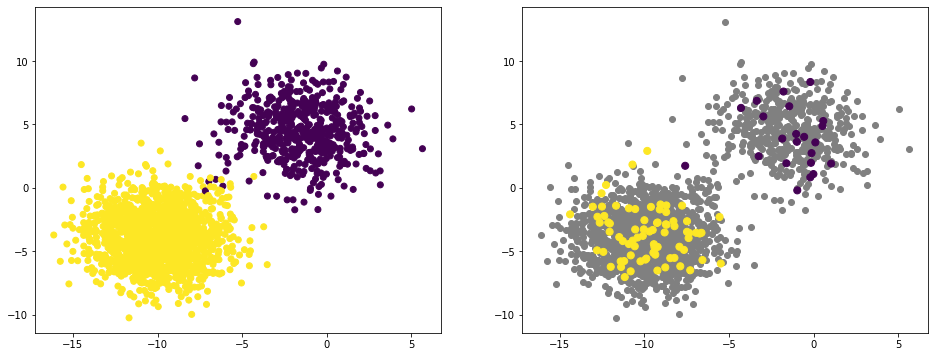

In [61]:
np.random.seed(1)

plt.figure(figsize=(16,6))

num_labeled,num_unlabeled = 100,1900
total_num = num_labeled + num_unlabeled
num_features = 2
X,y = datasets.make_blobs(n_samples=[500,1500],n_features=num_features,centers=None,cluster_std=[2.2,2])
y[y==0] = -1
plt.subplot(121)
plt.scatter(X[:,0],X[:,1],c=y)


labeled_idxs = np.random.choice(np.arange(0,total_num),num_labeled,replace=False)
X_labeled = X[labeled_idxs,:]
y_labeled = y[labeled_idxs].reshape(-1,1)
X_unlabeled = np.delete(X,labeled_idxs,axis=0)
true_y_unlabeled = np.delete(y,labeled_idxs).reshape(-1,1)
y_unlabeled = np.random.uniform(low=-1,high=1,size=num_unlabeled).reshape(-1,1)

plt.subplot(122)
plt.scatter(X_unlabeled[:,0],X_unlabeled[:,1],c="gray")
plt.scatter(X_labeled[:,0],X_labeled[:,1],c=y_labeled.reshape(-1),s=50)
plt.show()

In [64]:
W_lu, W_uu = build_similarity_matrices("gaussian",sigma=0.5,epsilon=1)

In [65]:
hessian = -2*W_uu
diagonal = 2*np.sum(W_lu,axis=0)+2*np.sum(W_uu,axis=0) - 2*np.diag(W_uu)
np.fill_diagonal(hessian,diagonal)

In [66]:
print(f"shape dell'hessiana: {hessian.shape}")
print(f"simmetria dell'hessiana: {check_symmetric(hessian)}")
w,v = np.linalg.eig(hessian)
L = np.max(w)

print(f"tutti gli autovalori dell'hessiana sono positivi: {np.all(w>=0)}")
print(f"autovalore massimo: {np.max(w)}")
print(f"fixed step size basata su autovalore massimo: {1/np.max(w)}")

shape dell'hessiana: (1900, 1900)
simmetria dell'hessiana: True
tutti gli autovalori dell'hessiana sono positivi: True
autovalore massimo: 185.63089372976194
fixed step size basata su autovalore massimo: 0.005387034344917725


In [67]:
Q = hessian # second derivatives, doesn't change during training
x = y_unlabeled # changes during training
c = 2*np.dot(W_lu.T,y_labeled) # fixed, doesn't change
k = np.sum((np.dot(W_lu.T,y_labeled**2))) # constant, doesn't change

In [68]:
# stop loss calculation
_,_,losses,_,_ = standard_gd(x.copy(),Q,c,k,method="exact",verbose=False,max_iter=2000)
objective_loss = losses[-1]+0.03*losses[-1] #3% error allowed
objective_loss

2.7387476367955785

### Exact stepsize comparison

In [69]:
# standard gradient descent
gd_x, gd_it, gd_losses, gd_times, gd_norms = standard_gd(x.copy(),
                                                         Q,c,k,
                                                         method="exact",
                                                         verbose=False,
                                                         max_iter=2500,
                                                         stop_loss=objective_loss)
gd_predictions = np.where(gd_x>=0,1,-1)

In [70]:
# randomized BCGD
rnd_x, rnd_it, rnd_losses, rnd_times, rnd_norms = randomized_BCGD(x.copy(),
                                                                  Q,c,k,
                                                                  method="exact",
                                                                  verbose=False,
                                                                  max_iter=2e6,
                                                                  stop_loss=objective_loss)
rnd_predictions = np.where(rnd_x>=0,1,-1)

In [71]:
# cyclic BCGD
cyc_x, cyc_it, cyc_losses, cyc_times, cyc_norms = cyclic_BCGD(x.copy(),
                                                              Q,c,k,
                                                              method="exact",
                                                              verbose=False,
                                                              max_iter=1500,
                                                              stop_loss=objective_loss)
cyc_predictions = np.where(cyc_x>=0,1,-1)

In [72]:
## accuracies:
gd_accuracy = sum(true_y_unlabeled == gd_predictions)/num_unlabeled
rnd_accuracy = sum(true_y_unlabeled == rnd_predictions)/num_unlabeled
cyc_accuracy = sum(true_y_unlabeled == cyc_predictions)/num_unlabeled

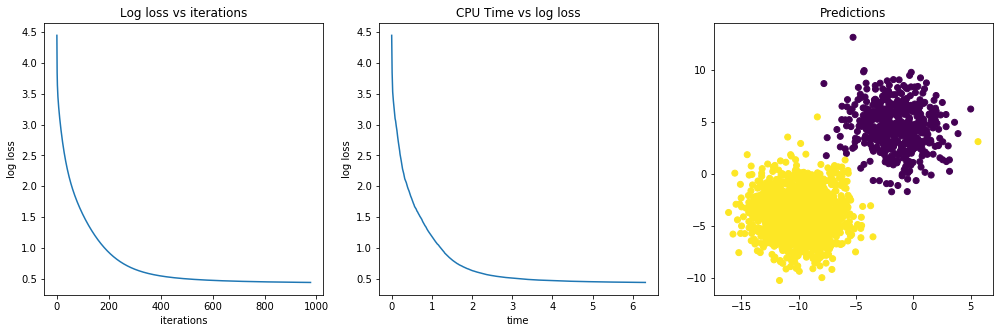

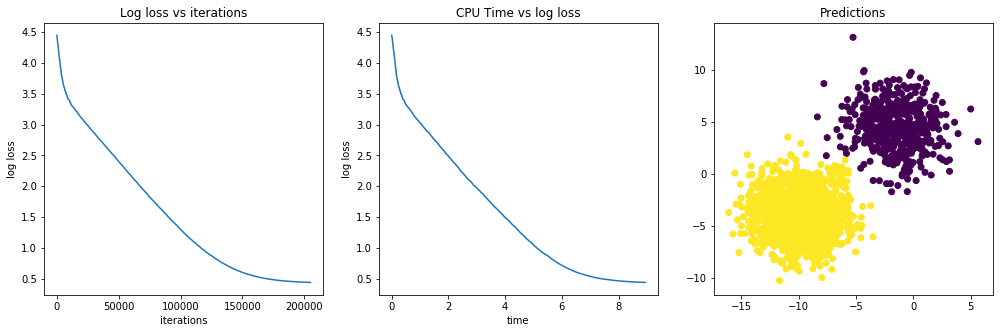

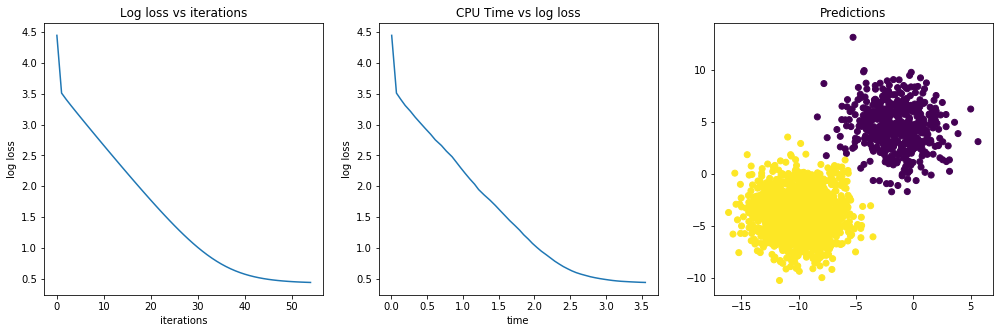

In [73]:
display_results(gd_x,gd_losses,gd_times,gd_predictions,0,1)
display_results(rnd_x,rnd_losses,rnd_times,rnd_predictions,0,1)
display_results(cyc_x,cyc_losses,cyc_times,cyc_predictions,0,1)

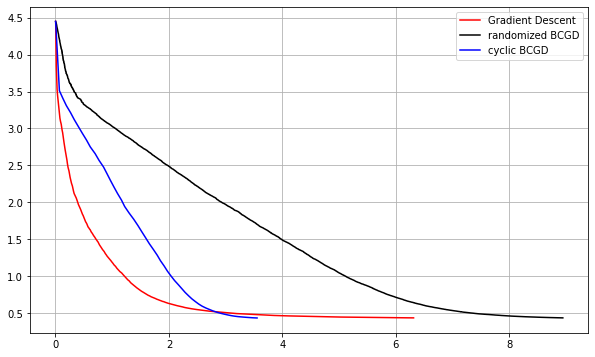

In [74]:
plt.figure(figsize=(10,6))
plt.plot(gd_times,np.log10(gd_losses),c="red",label="Gradient Descent")
plt.plot(rnd_times,np.log10(rnd_losses),c="black",label="randomized BCGD")
plt.plot(cyc_times,np.log10(cyc_losses),c="blue",label="cyclic BCGD")
plt.legend(loc="upper right")
plt.grid("on")
plt.show()

In [75]:
print("Accuracies:")
print(f"Gradient Descent: {gd_accuracy}")
print(f"Randomized BCGD: {rnd_accuracy}")
print(f"Cyclic BCGD: {cyc_accuracy}")

Accuracies:
Gradient Descent: [0.99578947]
Randomized BCGD: [0.99684211]
Cyclic BCGD: [0.99684211]


In [76]:
rnd_losses[-1],cyc_losses[-1],gd_losses[-1]

(2.738718152487254, 2.7298816887377173, 2.7387200436887724)

### Fixed stepsize comparison

In [386]:
gd_x, gd_it, gd_losses, gd_times, gd_norms = standard_gd(x.copy(),
                                                         Q,c,k,
                                                         method="fixed",
                                                         L=L,
                                                         verbose=False,
                                                         stop_loss=objective_loss,
                                                         max_iter=1000)
gd_predictions = np.where(gd_x>=0,1,-1)


rnd_x, rnd_it, rnd_losses, rnd_times, rnd_norms = randomized_BCGD(x.copy(),
                                                                  Q,c,k,
                                                                  method="fixed",
                                                                  L=L,
                                                                  verbose=False,
                                                                  stop_loss=objective_loss,
                                                                  max_iter=5e6)
rnd_predictions = np.where(rnd_x>=0,1,-1)


cyc_x, cyc_it, cyc_losses, cyc_times, cyc_norms = cyclic_BCGD(x.copy(),
                                                              Q,c,k,
                                                              method="fixed",
                                                              L=L,
                                                              verbose=False,
                                                              epsilon=10e-8,
                                                              stop_loss=objective_loss,
                                                              max_iter=1000)
cyc_predictions = np.where(cyc_x>=0,1,-1)

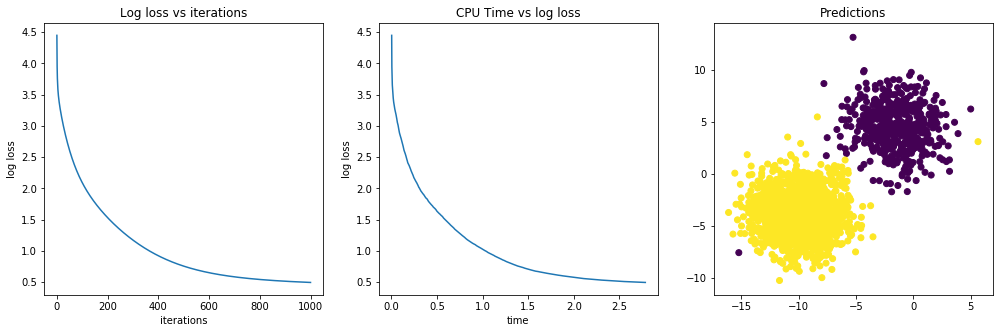

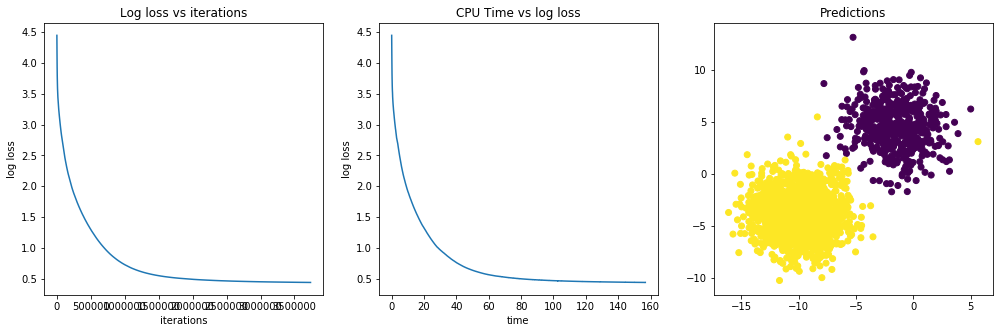

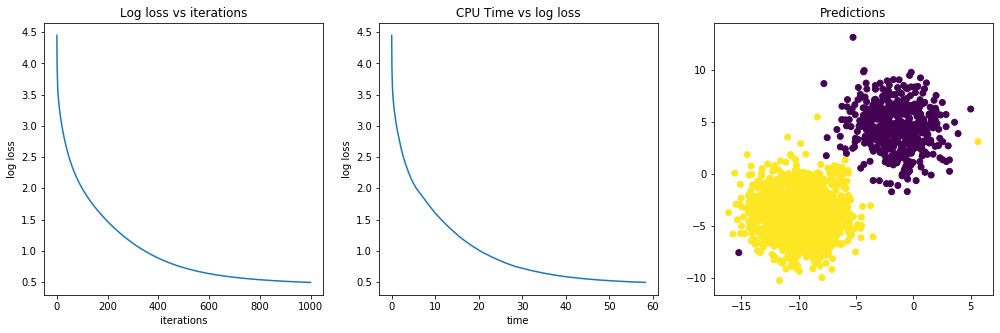

In [387]:
display_results(gd_x,gd_losses,gd_times,gd_predictions,0,1)
display_results(rnd_x,rnd_losses,rnd_times,rnd_predictions,0,1)
display_results(cyc_x,cyc_losses,cyc_times,cyc_predictions,0,1)

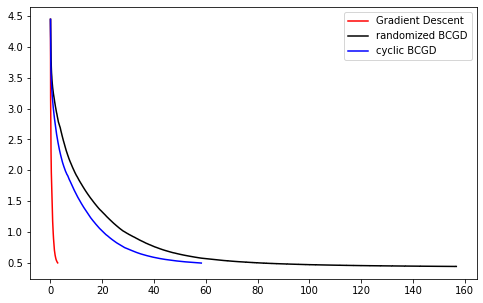

In [393]:
plt.figure(figsize=(8,5))
plt.plot(gd_times,np.log10(gd_losses),c="red",label="Gradient Descent")
plt.plot(rnd_times,np.log10(rnd_losses),c="black",label="randomized BCGD")
plt.plot(cyc_times,np.log10(cyc_losses),c="blue",label="cyclic BCGD")
plt.legend()
plt.show()

In [389]:
## accuracies:
gd_accuracy = sum(true_y_unlabeled == gd_predictions)/num_unlabeled
rnd_accuracy = sum(true_y_unlabeled == rnd_predictions)/num_unlabeled
cyc_accuracy = sum(true_y_unlabeled == cyc_predictions)/num_unlabeled

In [390]:
print("Accuracies:")
print(f"Gradient Descent: {gd_accuracy}")
print(f"Randomized BCGD: {rnd_accuracy}")
print(f"Cyclic BCGD: {cyc_accuracy}")

Accuracies:
Gradient Descent: [0.99526316]
Randomized BCGD: [0.99578947]
Cyclic BCGD: [0.99526316]


In [391]:
rnd_losses[-1],cyc_losses[-1],gd_losses[-1]

(2.738741213063168, 3.108956217808056, 3.1304905039346522)

### Section 2.1: Study of the effect of the dimensionality of the problem

Accuracies case 1:
Gradient Descent: [1.]
Randomized BCGD: [1.]
Cyclic BCGD: [1.]

Accuracies case 2:
Gradient Descent: [1.]
Randomized BCGD: [1.]
Cyclic BCGD: [1.]

Accuracies case 3:
Gradient Descent: [1.]
Randomized BCGD: [1.]
Cyclic BCGD: [1.]



c:\users\alvis\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
c:\users\alvis\appdata\local\programs\python\python37\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


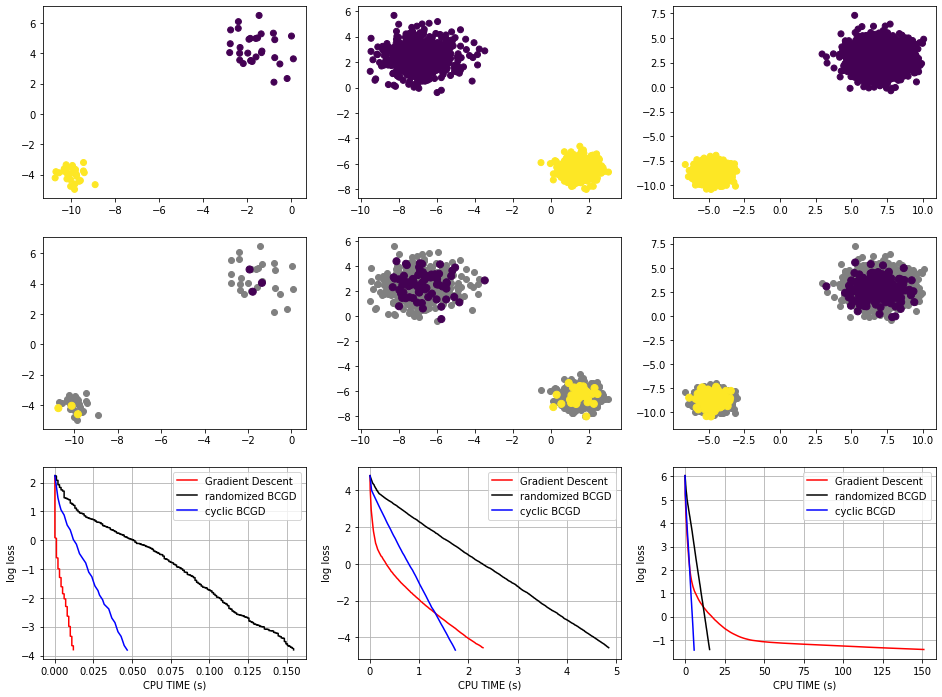

In [81]:
labeled_unlabeled = [(6,54),(120,1080),(500,4500)]
np.random.seed(1)
plt.figure(figsize=(16,12))
for i in range(len(labeled_unlabeled)):
    
    num_labeled,num_unlabeled = labeled_unlabeled[i]
    total_num = num_labeled + num_unlabeled
    num_features = 2
    X,y = datasets.make_blobs(n_samples=[total_num//2,total_num//2],n_features=num_features,centers=None,cluster_std=[1,0.5])
    y[y==0] = -1
    plt.subplot(3,3,i+1)
    plt.scatter(X[:,0],X[:,1],c=y)

    labeled_idxs = np.random.choice(np.arange(0,total_num),num_labeled,replace=False)
    X_labeled = X[labeled_idxs,:]
    y_labeled = y[labeled_idxs].reshape(-1,1)
    X_unlabeled = np.delete(X,labeled_idxs,axis=0)
    true_y_unlabeled = np.delete(y,labeled_idxs).reshape(-1,1)
    y_unlabeled = np.random.uniform(low=-1,high=1,size=num_unlabeled).reshape(-1,1)

    plt.subplot(3,3,(i+1)+3)
    plt.scatter(X_unlabeled[:,0],X_unlabeled[:,1],c="gray")
    plt.scatter(X_labeled[:,0],X_labeled[:,1],c=y_labeled.reshape(-1),s=50)
    
    W_lu, W_uu = build_similarity_matrices("gaussian",sigma=0.5,epsilon=1)
    hessian = -2*W_uu
    diagonal = 2*np.sum(W_lu,axis=0)+2*np.sum(W_uu,axis=0) - 2*np.diag(W_uu)
    np.fill_diagonal(hessian,diagonal)
    
    Q = hessian
    x = y_unlabeled
    c = 2*np.dot(W_lu.T,y_labeled)
    k = np.sum((np.dot(W_lu.T,y_labeled**2)))
    
    #calculating objective loss
    _,_,losses,_,_ = standard_gd(x.copy(),Q,c,k,method="exact",verbose=False,max_iter=5000)
    objective_loss = losses[-1]
    objective_loss += 0.03*objective_loss # 3% error allowed
    
    
    #exact stepsize comparisons
    gd_x, gd_it, gd_losses, gd_times, gd_norms = standard_gd(x.copy(),
                                                         Q,c,k,
                                                         method="exact",
                                                         verbose=False,
                                                         max_iter=5000,
                                                         stop_loss=objective_loss)
    gd_predictions = np.where(gd_x>=0,1,-1)
    
    rnd_x, rnd_it, rnd_losses, rnd_times, rnd_norms = randomized_BCGD(x.copy(),
                                                                  Q,c,k,
                                                                  method="exact",
                                                                  verbose=False,
                                                                  max_iter=2e6,
                                                                  stop_loss=objective_loss)
    rnd_predictions = np.where(rnd_x>=0,1,-1)
    
    cyc_x, cyc_it, cyc_losses, cyc_times, cyc_norms = cyclic_BCGD(x.copy(),
                                                              Q,c,k,
                                                              method="exact",
                                                              verbose=False,
                                                              max_iter=2500,
                                                              stop_loss=objective_loss)
    cyc_predictions = np.where(cyc_x>=0,1,-1)
    
    # accuracies calculation:
    
    gd_accuracy = sum(true_y_unlabeled == gd_predictions)/num_unlabeled
    rnd_accuracy = sum(true_y_unlabeled == rnd_predictions)/num_unlabeled
    cyc_accuracy = sum(true_y_unlabeled == cyc_predictions)/num_unlabeled
    
    # comparison CPU time vs log-loss three cases
    
    plt.subplot(3,3,(i+1)+6)
    plt.plot(gd_times,np.log10(gd_losses),c="red",label="Gradient Descent")
    plt.plot(rnd_times,np.log10(rnd_losses),c="black",label="randomized BCGD")
    plt.plot(cyc_times,np.log10(cyc_losses),c="blue",label="cyclic BCGD")
    plt.legend()
    plt.xlabel("CPU TIME (s)")
    plt.ylabel("log loss")
    plt.grid("on")
    
    print(f"Accuracies case {i+1}:")
    print(f"Gradient Descent: {gd_accuracy}")
    print(f"Randomized BCGD: {rnd_accuracy}")
    print(f"Cyclic BCGD: {cyc_accuracy}\n")
    
    
plt.savefig("dimensionality.png")    
plt.show()

### Section 3: Application on multidimensional artificial dataset: Oranges vs Grapes

dataset found on kaggle: <a href="https://www.kaggle.com/joshmcadams/oranges-vs-grapefruit">link</a>

In [295]:
from sklearn.preprocessing import StandardScaler

In [296]:
scaler = StandardScaler()

In [297]:
df2 = pd.read_csv("citrus.csv")

In [298]:
sub1 = df2[df2.name == "orange"]
sub2 = df2[df2.name == "grapefruit"]
sub1.shape,sub2.shape

((5000, 6), (5000, 6))

In [299]:
sub1 = sub1.iloc[:2000,:]
sub2 = sub2.iloc[:2000,:]

In [300]:
X = np.array(list(sub1.iloc[:,1:].to_numpy()) + list(sub2.iloc[:,1:].to_numpy()))
X_scaled = scaler.fit_transform(X)

In [301]:
y = np.array(list(sub1.iloc[:,0]) + list(sub2.iloc[:,0]))
y = y.reshape(-1,1)
y = np.where(y == "orange",1,-1)

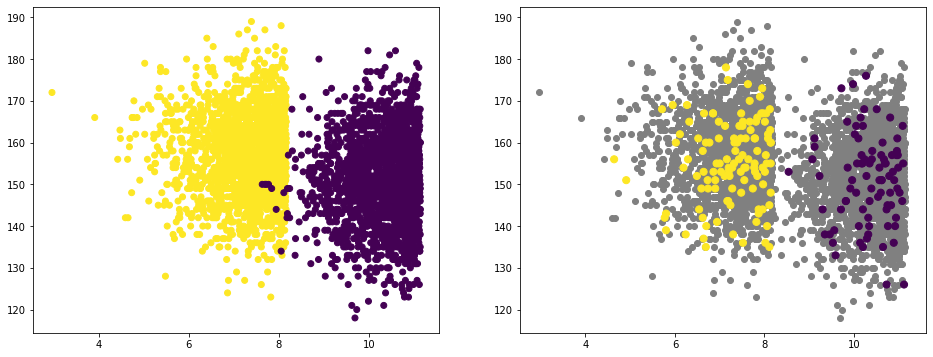

In [303]:
np.random.seed(1)

plt.figure(figsize=(16,6))

plt.subplot(121)
plt.scatter(X[:,0],X[:,2],c=y.flatten())


num_labeled,num_unlabeled = 200,3800
tot = num_labeled+num_unlabeled
num_features = 5
idxs = np.random.choice(np.arange(0,tot),num_labeled,replace=False)
X_labeled = X[idxs,:]
y_labeled = y[idxs].reshape(-1,1)
X_unlabeled = np.delete(X,idxs,axis=0)
true_y_unlabeled = np.delete(y,idxs).reshape(-1,1)
y_unlabeled = np.random.uniform(low=-1,high=1,size=num_unlabeled).reshape(-1,1)

plt.subplot(122)
plt.scatter(X_unlabeled[:,0],X_unlabeled[:,2],c="gray")
plt.scatter(X_labeled[:,0],X_labeled[:,2],c=y_labeled.reshape(-1),s=50)
plt.show()

In [304]:
W_lu, W_uu = build_similarity_matrices("gaussian",sigma=1*num_features//(3/2),epsilon=1) #in case of high dimensionality or/and far clusters sigma must be large

In [305]:
np.max(W_lu),np.min(W_lu),np.max(W_uu),np.min(W_uu)

(0.9939185672274535, 0.0, 1.0, 0.0)

In [306]:
hessian = -2*W_uu
diagonal = 2*np.sum(W_lu,axis=0)+2*np.sum(W_uu,axis=0) - 2*np.diag(W_uu)
np.fill_diagonal(hessian,diagonal)

In [307]:
print(f"shape dell'hessiana: {hessian.shape}")
print(f"simmetria dell'hessiana: {check_symmetric(hessian)}")
w,v = np.linalg.eig(hessian)
L = np.max(w)
print(f"tutti gli autovalori dell'hessiana sono positivi: {np.all(w>=0)}")
print(f"autovalore massimo: {np.max(w)}")
print(f"fixed step size basata su autovalore massimo: {1/np.max(w)}")

shape dell'hessiana: (3800, 3800)
simmetria dell'hessiana: True
tutti gli autovalori dell'hessiana sono positivi: True
autovalore massimo: 71.14755862074963
fixed step size basata su autovalore massimo: 0.014055296054928267


In [308]:
Q = hessian 
x = y_unlabeled
c = 2*np.dot(W_lu.T,y_labeled)
k = np.sum((np.dot(W_lu.T,y_labeled**2)))

In [309]:
_,_,losses,_,_ = standard_gd(x.copy(),Q,c,k,method="exact",verbose=False,max_iter=2000)
objective_loss = losses[-1]+0.03*losses[-1] #3% error allowed
objective_loss

27.232780861350108

In [310]:
## exact stepsize comparison

gd_x, gd_it, gd_losses, gd_times, gd_norms = standard_gd(x.copy(),
                                                         Q,c,k,
                                                         method="exact",
                                                         verbose=False,
                                                         max_iter=1000,
                                                         stop_loss=objective_loss)
gd_predictions = np.where(gd_x>=0,1,-1)

In [311]:
rnd_x, rnd_it, rnd_losses, rnd_times, rnd_norms = randomized_BCGD(x.copy(),
                                                                  Q,c,k,
                                                                  method="exact",
                                                                  verbose=False,
                                                                  max_iter=1e6,
                                                                  stop_loss=objective_loss)
rnd_predictions = np.where(rnd_x>=0,1,-1)

In [312]:
cyc_x, cyc_it, cyc_losses, cyc_times, cyc_norms = cyclic_BCGD(x.copy(),
                                                              Q,c,k,
                                                              method="exact",
                                                              verbose=False,
                                                              max_iter=1000,
                                                              stop_loss=objective_loss)
cyc_predictions = np.where(cyc_x>=0,1,-1)

In [313]:
## accuracies:
gd_accuracy = sum(true_y_unlabeled == gd_predictions)/num_unlabeled
rnd_accuracy = sum(true_y_unlabeled == rnd_predictions)/num_unlabeled
cyc_accuracy = sum(true_y_unlabeled == cyc_predictions)/num_unlabeled

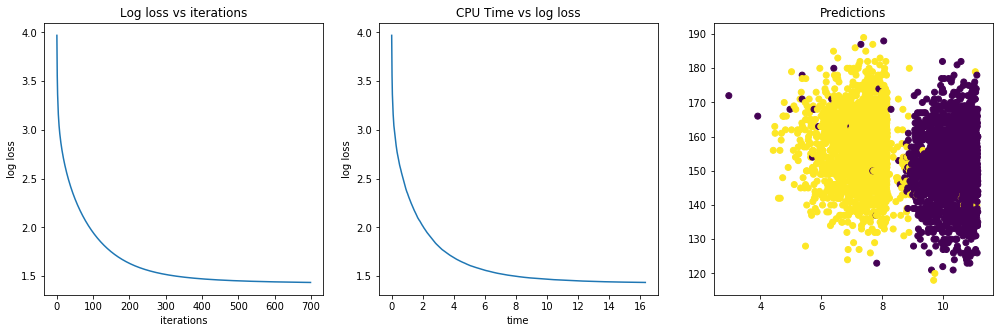

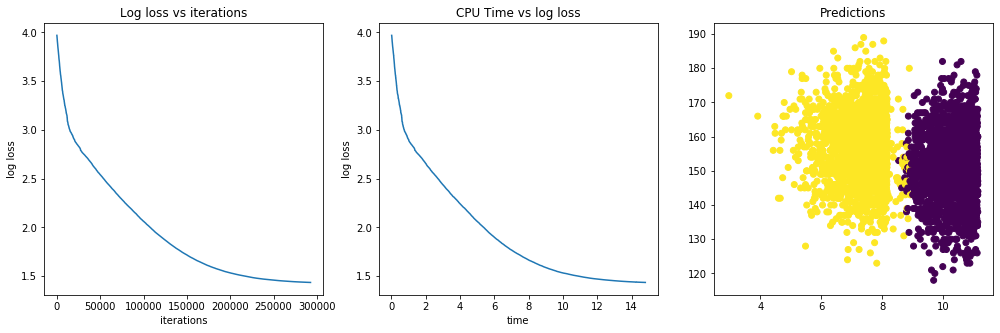

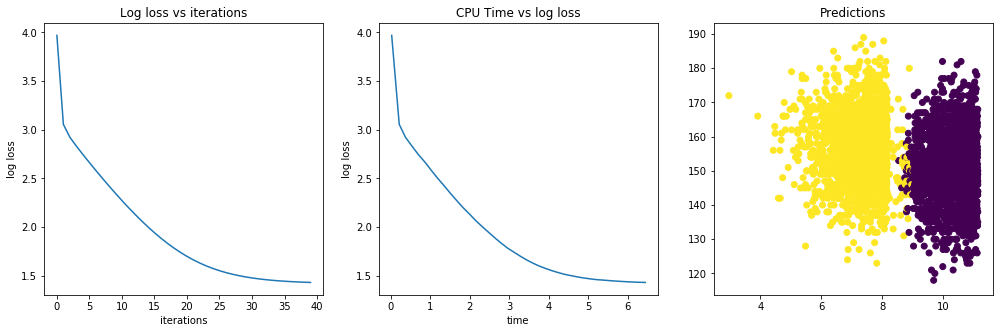

In [314]:
display_results(gd_x,gd_losses,gd_times,gd_predictions,0,2)
display_results(rnd_x,rnd_losses,rnd_times,rnd_predictions,0,2)
display_results(cyc_x,cyc_losses,cyc_times,cyc_predictions,0,2)

In [315]:
print("Accuracies:")
print(f"Gradient Descent: {gd_accuracy}")
print(f"Randomized BCGD: {rnd_accuracy}")
print(f"Cyclic BCGD: {cyc_accuracy}")

Accuracies:
Gradient Descent: [0.97842105]
Randomized BCGD: [0.98552632]
Cyclic BCGD: [0.98473684]


c:\users\alvis\appdata\local\programs\python\python37\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


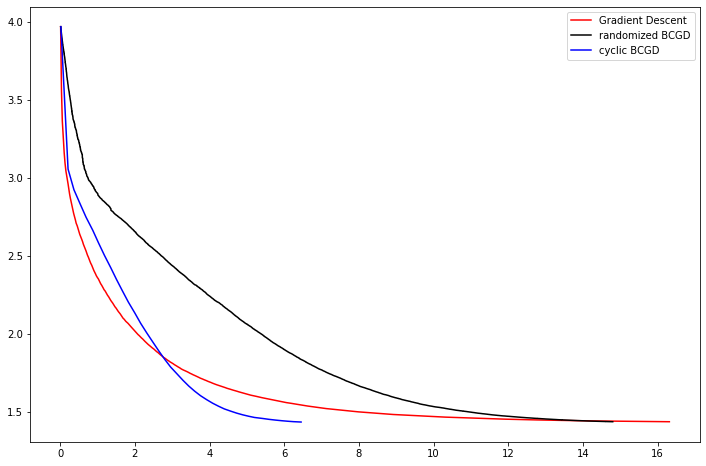

In [316]:
plt.figure(figsize=(12,8))
plt.plot(gd_times,np.log10(gd_losses),c="red",label="Gradient Descent")
plt.plot(rnd_times,np.log10(rnd_losses),c="black",label="randomized BCGD")
plt.plot(cyc_times,np.log10(cyc_losses),c="blue",label="cyclic BCGD")
plt.legend()
plt.show()

### Section 4: Real Dataset application: Pulsars Classification

This dataset was found at: <a href="https://www.kaggle.com/colearninglounge/predicting-pulsar-starintermediate">link </a>on Kaggle.

In [32]:
df3 = pd.read_csv("pulsar_data_train.csv",sep=",",dtype=np.float64)

In [33]:
df3 = df3.dropna()

In [34]:
positives = df3[df3.target_class == 1]
negatives = df3[df3.target_class == 0].iloc[:2150,:]

In [35]:
positives.shape,negatives.shape

((850, 9), (2150, 9))

In [36]:
df3 = pd.concat([positives,negatives])

In [37]:
for column in df3.columns[:-1]: #standardization
    mu = df3[column].mean()
    sd = df3[column].std()
    df3[column] = (df3[column]-mu)/sd

In [38]:
y = df3.target_class.to_numpy()
X = df3.iloc[:,:-1].to_numpy()

In [39]:
y[y==0] = -1

In [40]:
np.sum(y==1)/len(y)

0.2833333333333333

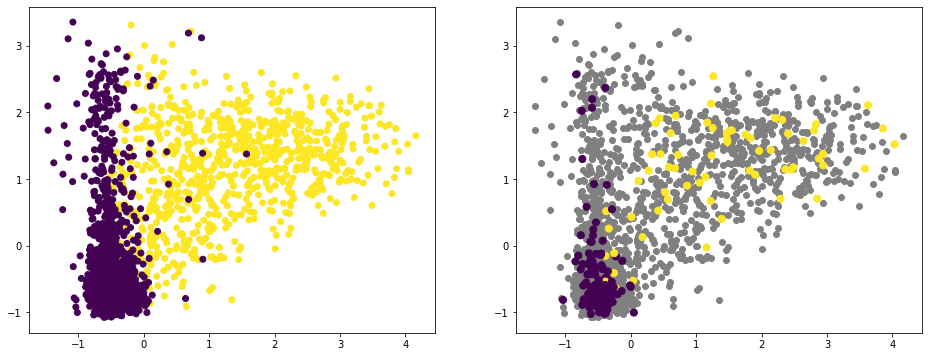

In [41]:
np.random.seed(1)

plt.figure(figsize=(16,6))

plt.subplot(121)
plt.scatter(X[:,2],X[:,5],c=y)


num_labeled,num_unlabeled = 200,2800
tot = num_labeled+num_unlabeled
num_features = 8
idxs = np.random.choice(np.arange(0,tot),num_labeled,replace=False)
X_labeled = X[idxs,:]
y_labeled = y[idxs].reshape(-1,1)
X_unlabeled = np.delete(X,idxs,axis=0)
true_y_unlabeled = np.delete(y,idxs).reshape(-1,1)
y_unlabeled = np.random.uniform(low=-1,high=1,size=num_unlabeled).reshape(-1,1)

plt.subplot(122)
plt.scatter(X_unlabeled[:,2],X_unlabeled[:,5],c="gray")
plt.scatter(X_labeled[:,2],X_labeled[:,5],c=y_labeled.reshape(-1),s=50)
plt.show()

In [42]:
W_lu, W_uu = build_similarity_matrices("gaussian",sigma=0.5,epsilon=1)
np.max(W_lu),np.min(W_lu),np.max(W_uu),np.min(W_uu)

(0.9909561553367862, 1.0964852664826949e-229, 1.0, 2.762389747156467e-228)

In [43]:
hessian = -2*W_uu
diagonal = 2*np.sum(W_lu,axis=0)+2*np.sum(W_uu,axis=0) - 2*np.diag(W_uu)
np.fill_diagonal(hessian,diagonal)

In [44]:
print(f"shape dell'hessiana: {hessian.shape}")
print(f"simmetria dell'hessiana: {check_symmetric(hessian)}")
w,v = np.linalg.eig(hessian)
L = np.max(w)
print(f"tutti gli autovalori dell'hessiana sono positivi: {np.all(w>=0)}")
print(f"autovalore massimo: {np.max(w)}")
print(f"fixed step size basata su autovalore massimo: {1/np.max(w)}")

shape dell'hessiana: (2800, 2800)
simmetria dell'hessiana: True
tutti gli autovalori dell'hessiana sono positivi: True
autovalore massimo: 775.8423885596012
fixed step size basata su autovalore massimo: 0.0012889215834888334


In [45]:
Q = hessian 
x = y_unlabeled 
c = 2*np.dot(W_lu.T,y_labeled) 
k = np.sum((np.dot(W_lu.T,y_labeled**2)))

In [46]:
_,_,losses,_,_ = standard_gd(x.copy(),Q,c,k,method="exact",verbose=False,max_iter=2000)
objective_loss = losses[-1]+0.01*losses[-1] #1% error allowed
objective_loss

4739.5211271683465

In [47]:
## exact stepsize comparison

gd_x, gd_it, gd_losses, gd_times, gd_norms = standard_gd(x.copy(),
                                                         Q,c,k,
                                                         method="exact",
                                                         verbose=False,
                                                         max_iter=500,
                                                         stop_loss = objective_loss)
gd_predictions = np.where(gd_x>=0,1,-1)

In [48]:
rnd_x, rnd_it, rnd_losses, rnd_times, rnd_norms = randomized_BCGD(x.copy(),
                                                                  Q,c,k,
                                                                  method="exact",
                                                                  verbose=False,
                                                                  max_iter=2.5e5,
                                                                  stop_loss = objective_loss)
rnd_predictions = np.where(rnd_x>=0,1,-1)

In [49]:
cyc_x, cyc_it, cyc_losses, cyc_times, cyc_norms = cyclic_BCGD(x.copy(),
                                                              Q,c,k,
                                                              method="exact",
                                                              verbose=False,
                                                              max_iter=200,
                                                              stop_loss = objective_loss)
cyc_predictions = np.where(cyc_x>=0,1,-1)

In [50]:
## accuracies:
gd_accuracy = sum(true_y_unlabeled == gd_predictions)/num_unlabeled
rnd_accuracy = sum(true_y_unlabeled == rnd_predictions)/num_unlabeled
cyc_accuracy = sum(true_y_unlabeled == cyc_predictions)/num_unlabeled

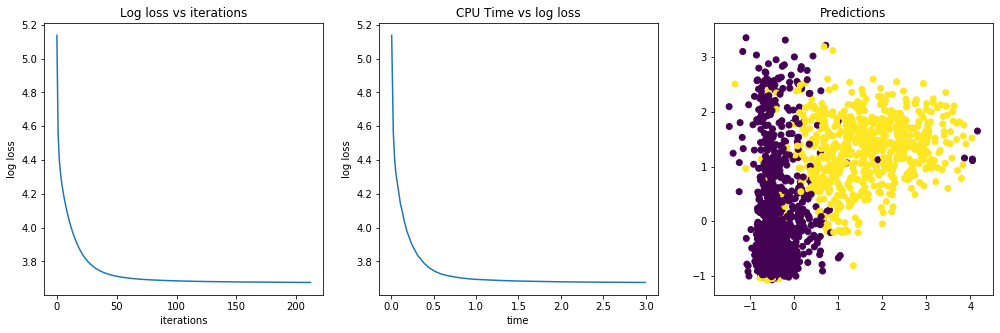

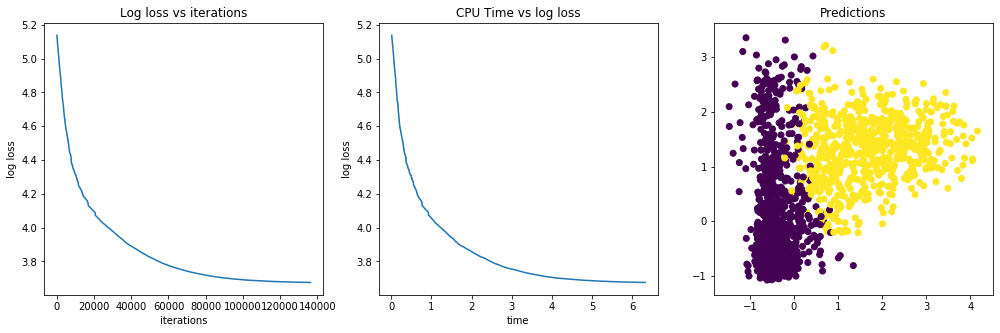

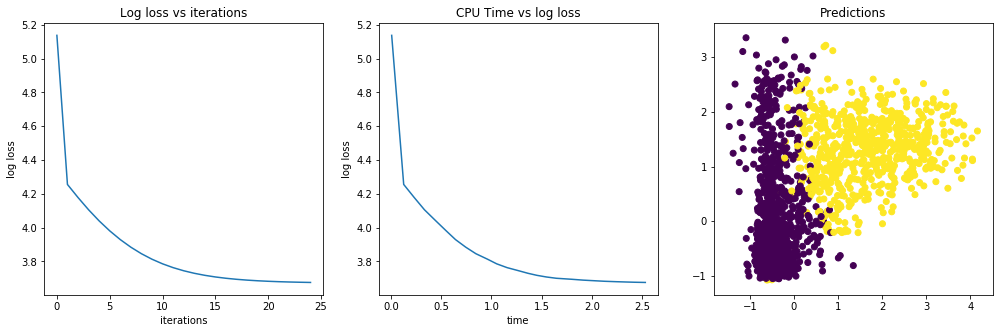

In [51]:
display_results(gd_x,gd_losses,gd_times,gd_predictions,2,5)
display_results(rnd_x,rnd_losses,rnd_times,rnd_predictions,2,5)
display_results(cyc_x,cyc_losses,cyc_times,cyc_predictions,2,5)

In [52]:
print("Accuracies:")
print(f"Gradient Descent: {gd_accuracy}")
print(f"Randomized BCGD: {rnd_accuracy}")
print(f"Cyclic BCGD: {cyc_accuracy}")

Accuracies:
Gradient Descent: [0.90964286]
Randomized BCGD: [0.91964286]
Cyclic BCGD: [0.91857143]


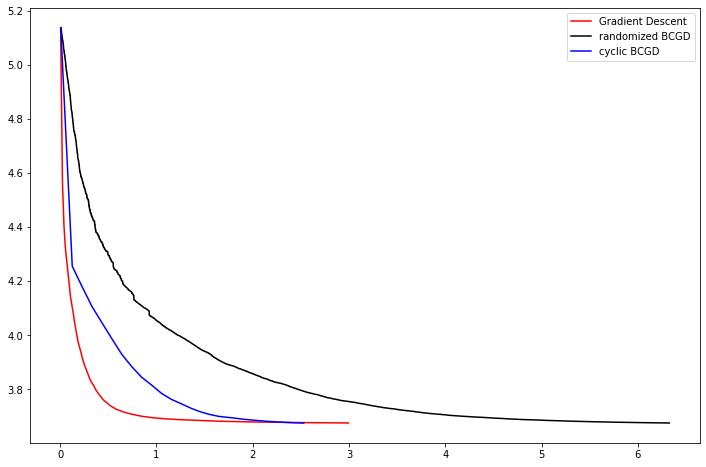

In [53]:
plt.figure(figsize=(12,8))
plt.plot(gd_times,np.log10(gd_losses),c="red",label="Gradient Descent")
plt.plot(rnd_times,np.log10(rnd_losses),c="black",label="randomized BCGD")
plt.plot(cyc_times,np.log10(cyc_losses),c="blue",label="cyclic BCGD")
plt.legend()
plt.show()

In [54]:
gd_losses[-1],cyc_losses[-1],rnd_losses[-1]

(4739.3251887689075, 4737.406157302125, 4739.519336539947)

In [55]:
from sklearn.metrics import classification_report

In [56]:
print(classification_report(rnd_predictions,true_y_unlabeled))

              precision    recall  f1-score   support

          -1       0.99      0.90      0.95      2214
           1       0.73      0.98      0.84       586

    accuracy                           0.92      2800
   macro avg       0.86      0.94      0.89      2800
weighted avg       0.94      0.92      0.92      2800

